In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# read df
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)

df['Date'] = pd.to_datetime(df['Date'])

# # Forward fill micro, macro, stock
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
# # Fill 0 to sentiment
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])
df.columns[df.isna().any()].tolist()

['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

In [17]:
import glob
import os

# Read articles df
csv_files = glob.glob(os.path.join("data", "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

In [18]:
df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

In [19]:
# 정렬
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# lag 생성 대상 컬럼과 시차
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7]

# lag feature를 저장할 리스트
lag_features = []

# lag된 컬럼들 생성
for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

# lag된 컬럼들 DataFrame으로 병합
lag_df = pd.concat(lag_features, axis=1)

# 원본 df와 합치기
df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

# # 필요 시 결측치 제거
# df = df.dropna().reset_index(drop=True)

In [20]:
# df[['Negative', 'Neutral', 'Positive']] = df[['Negative', 'Neutral', 'Positive']].fillna(0)
df = df.dropna(subset=['Negative', 'Neutral', 'Positive'])

In [21]:
from sklearn.decomposition import PCA

# 1. PCA 적용
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# 2. PCA 결과를 emb_pca_ 접두사 붙여서 DataFrame으로 변환
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)

# 3. 원래 데이터에서 emb_ 컬럼 제거
df_non_pca = df.drop(columns=emb_cols)

# 4. 두 DataFrame 합치기
df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_73,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.00076,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.00042
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.00076,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.00042
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.00076,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.00042
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.00076,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.00042
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.00076,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.00042


In [22]:
# df_pca = pd.concat([df_pca['Date'], df_pca[df_pca.columns[40:]]], axis=1)

In [23]:
df_pca.columns[df_pca.isna().any()].tolist()

['Target_1day',
 'Target_1week',
 'Target_1month',
 'Target_1year',
 'Open_lag1',
 'Open_lag3',
 'Open_lag5',
 'Open_lag7',
 'High_lag1',
 'High_lag3',
 'High_lag5',
 'High_lag7',
 'Low_lag1',
 'Low_lag3',
 'Low_lag5',
 'Low_lag7',
 'Close_lag1',
 'Close_lag3',
 'Close_lag5',
 'Close_lag7',
 'Volume_lag1',
 'Volume_lag3',
 'Volume_lag5',
 'Volume_lag7',
 'Dividends_lag1',
 'Dividends_lag3',
 'Dividends_lag5',
 'Dividends_lag7',
 'Stock Splits_lag1',
 'Stock Splits_lag3',
 'Stock Splits_lag5',
 'Stock Splits_lag7',
 'GDP (Billions USD)_lag1',
 'GDP (Billions USD)_lag3',
 'GDP (Billions USD)_lag5',
 'GDP (Billions USD)_lag7',
 'Unemployment Rate (%)_lag1',
 'Unemployment Rate (%)_lag3',
 'Unemployment Rate (%)_lag5',
 'Unemployment Rate (%)_lag7',
 'Producer Price Index (PPI)_lag1',
 'Producer Price Index (PPI)_lag3',
 'Producer Price Index (PPI)_lag5',
 'Producer Price Index (PPI)_lag7',
 'Retail Sales (Millions USD)_lag1',
 'Retail Sales (Millions USD)_lag3',
 'Retail Sales (Millions U

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV 설정
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 예측
    y_pred = best_model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
df_pca

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_73,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000760,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.000420
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000760,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.000420
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000760,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.000420
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000760,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.000420
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000760,-0.000131,-0.000766,0.000134,-0.000415,-0.000294,-0.000063,-0.000306,-0.000512,0.000420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,2025-01-27,124.788521,128.388181,116.689260,118.409103,818830900,0.0,0.0,29723.864,4.0,...,-0.424681,0.134606,-0.010949,-0.072257,-0.006195,0.042520,0.236244,0.162303,0.111636,-0.228374
4702,2025-01-28,121.798801,128.988143,116.239315,128.978149,579666400,0.0,0.0,29723.864,4.0,...,-0.056336,-0.036981,0.129555,0.157920,-0.022796,0.121092,0.076224,-0.040584,-0.055889,-0.149707
4703,2025-01-29,126.488367,126.878331,120.038963,123.688622,467120600,0.0,0.0,29723.864,4.0,...,0.214934,0.088054,-0.245146,-0.144514,0.234054,-0.209388,0.127644,0.084830,-0.169372,-0.016198
4704,2025-01-30,123.088674,124.988501,118.089134,124.638535,392925500,0.0,0.0,29723.864,4.0,...,-0.183115,0.153080,-0.009060,-0.072873,-0.163484,0.047444,-0.133136,0.080431,-0.023158,-0.221727


In [26]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
# random_forest(df_pca, 'Target_1month')
# random_forest(df_pca, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


ValueError: 
All the 18 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/utils/validation.py", line 899, in check_array
    _assert_all_finite(
  File "/opt/anaconda3/envs/dat490/lib/python3.9/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()
    
    # 1. 타겟 처리
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # 2. 날짜 처리
    df['Date'] = pd.to_datetime(df['Date'])

    # 3. 범주형 처리
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # 4. X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 5. 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 7. 하이퍼파라미터 그리드
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # 8. GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 9. 예측
    y_pred = best_model.predict(X_test)

    # 10. 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 11. 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22200
[LightGBM] [Info] Total Bins 22166
[LightGBM] [Info] Number of data points in the train set: 2507, number of used features: 93
[LightGBM] [Info] Number of data points in the train set: 2507, number of used features: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 2506,

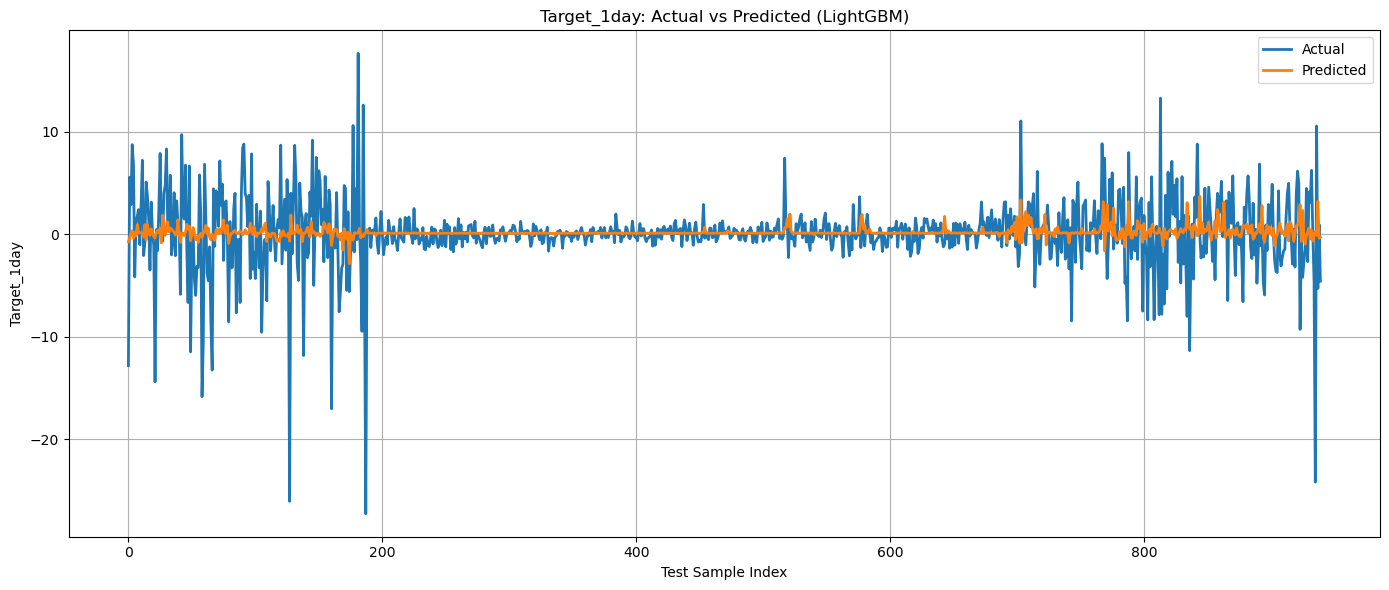

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22155
[LightGBM] [Info] Number of data points in the train set: 2493, number of used features: 94
[LightGBM] [Info] Start training from score 0.887556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22196
[LightGBM] [Info] Number of data points in the train set: 2493, number of used features: 93
[LightGBM] [Info] Start training from score 0.609289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22215
[LightGBM] [Info] Number of data points in the train se

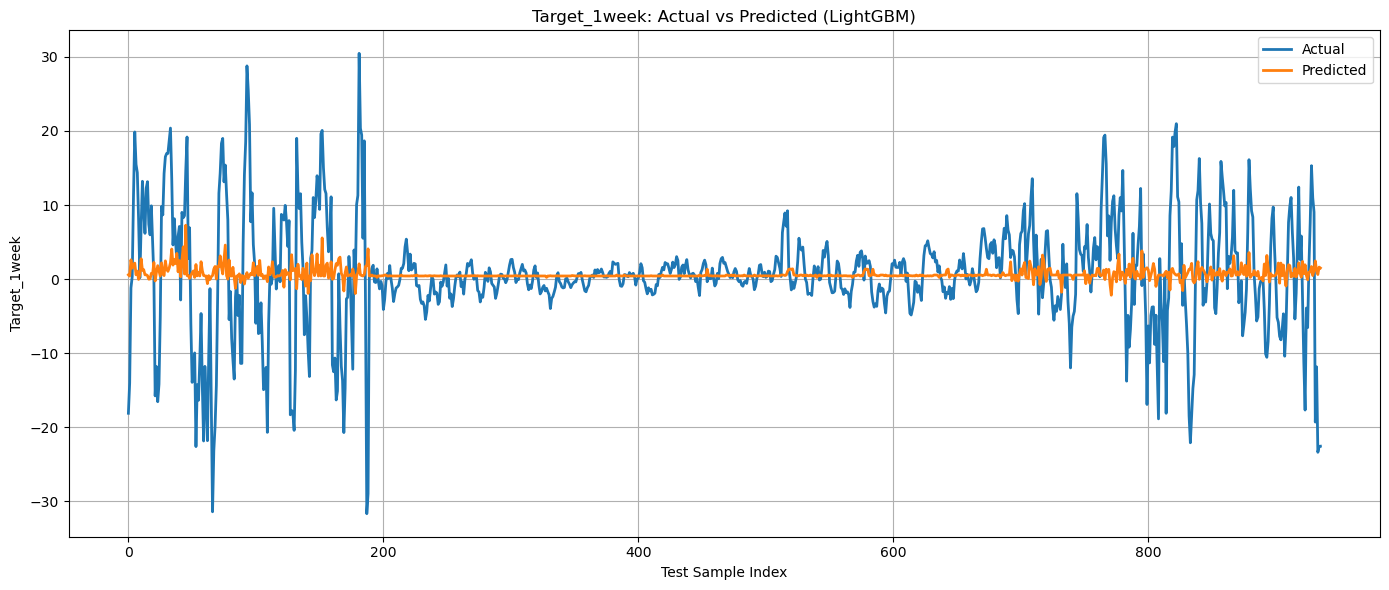

In [14]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
# lightgbm_model(df_pca, 'Target_1month')
# lightgbm_model(df_pca, 'Target_1year')